# Parallelized Cloud Computing with Dask for Geoscientists

Tutorial by [Ellianna Abrahams](https://elliesch.github.io)

The following notebook includes materials from notebooks written by [Hamed Alemohammad](https://hamedalemo.github.io/advanced-geo-python/lectures/dask_intro.html), [Ryan Abernathy](https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html), [Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook), [stackstac](https://stackstac.readthedocs.io/en/latest/basic.html), and [Dask](https://examples.dask.org/applications/image-processing.html).

For those that would like to follow along for the introductory section, please install `graphviz`.

In [2]:
conda install python-graphviz

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       hd4edc92_1         539 KB  conda-forge
    ca-certificates-2023.11.17 |       hbcca054_0         151 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    gdk-pixbuf-2.42.10         |       h6b639ba_2         560 KB  conda-forge
    graphviz-8.1.0             |       h28d9a01_0         2.2 MB  c

# An Introduction to Dask for Parallel Computing

Dask is a Python library designed to facilitate parallel computing and distributed data processing. It is particularly useful for handling computations that exceed the available memory of a single machine and for parallelizing tasks across multiple cores or even distributed clusters of machines. The primary goal of Dask is to provide a user-friendly and Pythonic interface for developers to scale their data analysis and processing workflows.

Dask consists of two main components:
1. **"Big Data" Collections:** Dask provides collections that extend common Python data structures, such as arrays, dataframes, and lists, to handle larger-than-memory or distributed datasets. These collections are designed to mimic the interfaces of popular libraries like NumPy and Pandas, making it easier for developers to transition from single-machine to distributed computing environments.
2. **Dynamic Task Scheduling:** Dask provides scheduling that manages the distribution and execution of tasks across the available computing resources. It ensures that computations are carried out efficiently in a parallelized manner.

![Dask Distributed System](https://docs.dask.org/en/stable/_images/dask-overview.svg)
High level collections are used to generate task graphs which can be executed by schedulers on a single machine or a cluster.

Some reasons why you should consider using Dask for your large data:

- **Scalable Parallel Computing:** Dask enables the parallelization of computations across multiple cores and distributed clusters, allowing users to efficiently handle data processing tasks that exceed the memory capacity of a single machine.
- **Lazy Evaluation:** Dask adopts a lazy evaluation approach, deferring the execution of operations until explicitly requested. This optimizes the scheduling and execution of computations, enhancing overall efficiency.
- **Flexibility Across Data Structures:** Dask provides "Big Data" collections that extend common Python data structures (e.g., arrays, dataframes, bags) to handle larger-than-memory or distributed datasets. This flexibility allows users to seamlessly transition between single-machine and distributed computing environments.
- **Integration with Distributed Computing:** Dask seamlessly integrates with a task scheduler, facilitating the scaling of computations from a single machine to distributed computing clusters. This adaptability makes Dask a versatile tool for handling diverse big data processing scenarios.

In essence, Dask offers a versatile and user-friendly framework for scalable, parallel, and distributed computing in Python, making it well-suited for a wide range of data analysis and processing tasks.

---

<br>

## Dask Arrays

Today, we'll be focusing on processing image data, i.e. array data, with `dask`, but it can also be used with most any familiar python data variables, like dataframes (`pandas`-like) for example.

A `dask` array is very similar to a `numpy` or `xarray` array. However, a `dask` array is only symbolic, and doesn't initially hold any data. It is structured to represent the shape, chunks, and computations needed to generate the data. Dask remains efficient by delaying computations until the full computation thread is built up and the data is requested. This mode of operation is called “lazy evaluation” and this mode allows users to build up a symbolic thread of calculations before turning them over the scheduler for execution.

`dask` arrays arrange many python arrays into a grid. The underlying arrays are stored either locally, or on a remote machine like the cloud.

![Visualization of a Dask Array](https://docs.dask.org/en/stable/_images/dask-array.svg)

Let's compare some `numpy` arrays to `dask` arrays to illustrate further how Dask operates. We'll begin by creating a `numpy` array of ones.

In [1]:
import numpy as np

In [3]:
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Let's look at the size of this array in memory:

In [4]:
print(f'Size in MB: {ones_np.nbytes / (1024 * 1024)}')

Size in MB: 30.517578125


Now, we'll create the same array in dask.

In [5]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

Notice how this array comes with a `dask` visualization of our array and includes the word "chunks." Chunks are the way that `dask` splits the array into sub-arrays. We did not specify how we wanted to chunk the array, so `dask` just used one chunk for the whole array. At this point, the `dask` array is very similar to the `numpy` array and isn't structured to take advantage of dask functionality.

## Specifying Chunks

To leverage the full power of `dask`, we'll split our array into specified chunks. The [Dask documentation](https://dask.pydata.org/en/latest/array-chunks.html) provides several ways to specify chunks. In this demonstration, we'll use a block shape.

In [6]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

At this point, all we have is a symbolic represetnation of the array, including its shape, data type, and chunk size. This is an example of lazy evalution; unlike `numpy`, `dask` has not generated data yet.

In order to generate data, we need to send the data collection to the scheduler, which we can do by calling the `compute` function.

In [7]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Dask has a nifty `visualize` function that illustrates the symbolic operations that ran when we called `compute`.

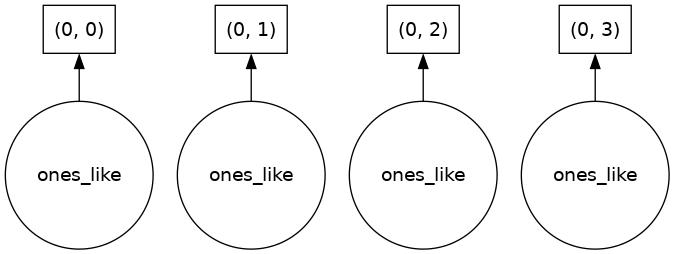

In [8]:
ones.visualize()

We can see that we stored four "ones-like" arrays, one in each chunk. To generate the data, the `dask` scheduler calls `np.ones` four times and then concatenates all of them together into one array.

Rather than immediately loading a `dask` array (which will store all of the data in RAM), we usually would like to do some kind of analysis on the data and don't necessarily want to store the full raw data in memory. Let's see how `dask` handles a more complex computation that reduces the data.

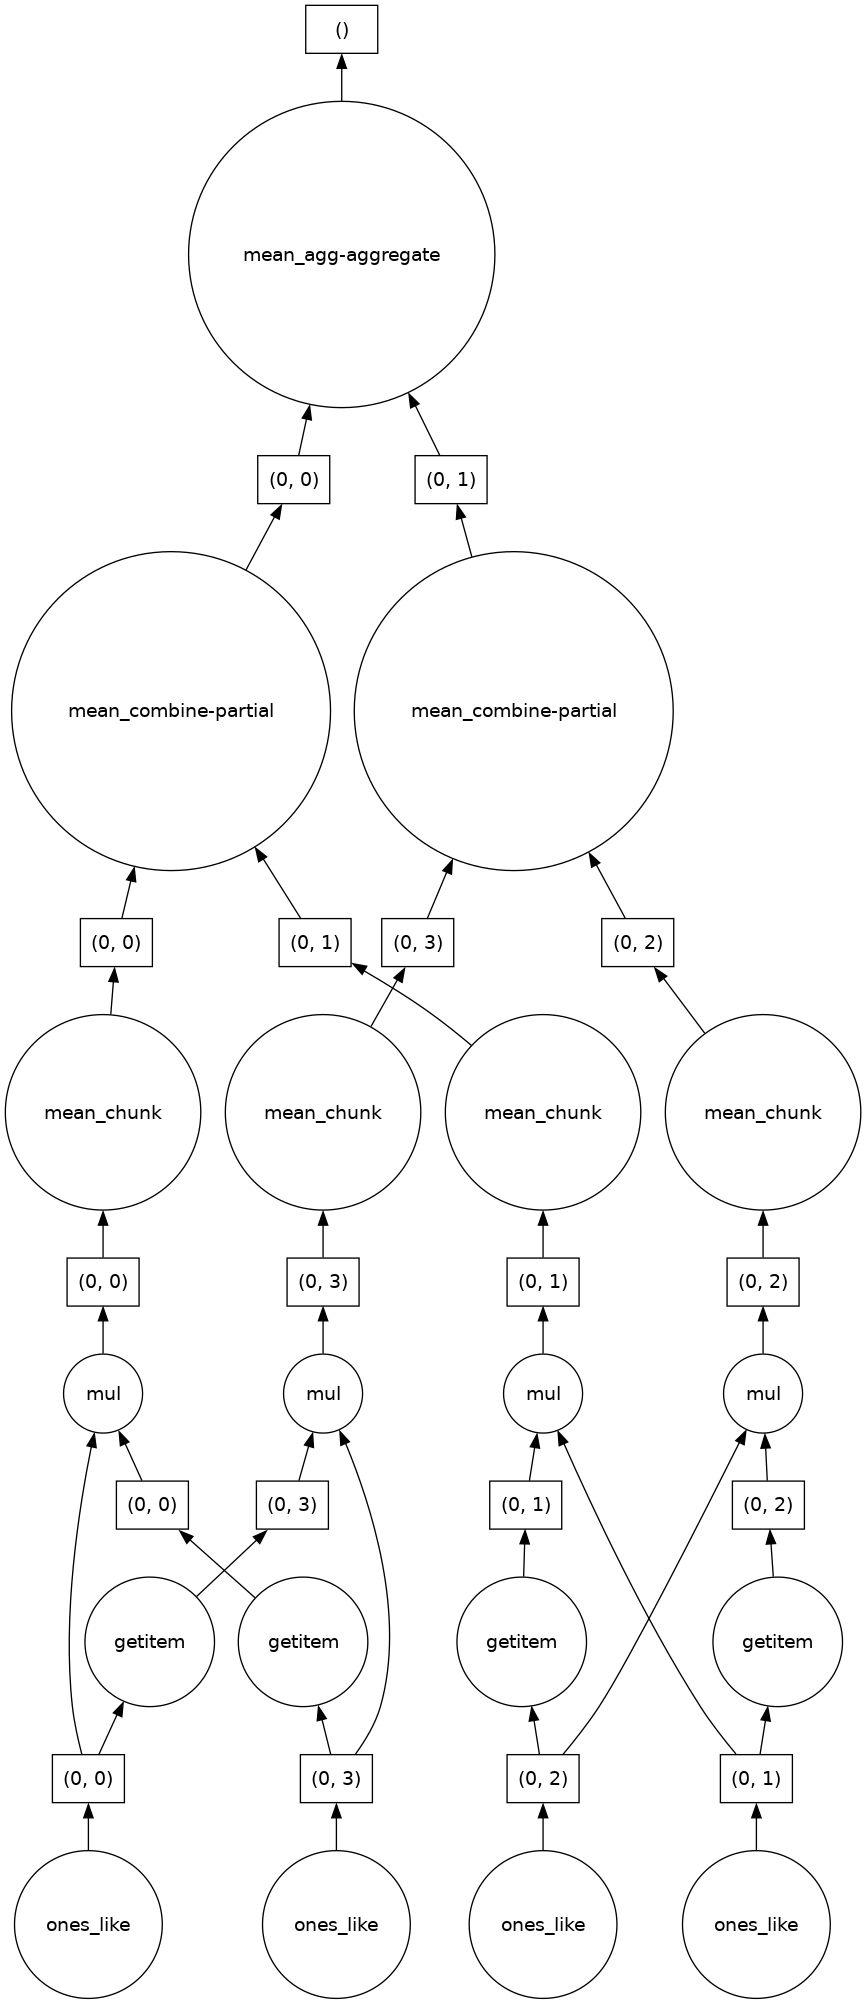

In [59]:
complex_calculation = (ones * ones[::-1, ::-1]).mean()
complex_calculation.visualize()

We can see Dask’s strategy for running the calculation thread on our data array. The power of Dask is that it automatically designs an algorithm appropriate for complex operation threads with big data.

---

<br>
<br>

# Dask For Geoscientific Images

### Learning Goals:
- Interacting with a Large Image using [Dask](https://www.dask.org/get-started)
    - Query a Landsat time-series using stackstac with Planetary Computer
    - Refine the image query before downloading data
    - Import the refined image
- Running Custom Functions on `Dask` + `xarray`
    - Using a custom function for analysis before importing data
    - Implementing scikit image on dask arrays

## Computing Environment

We will set up our computing environment with package imports. Today we'll be working with planetary computer, dask, xarray, and scikit image.

Tip: If you need to import a library that is not pre-installed, use `pip install <package-name>` in a Jupyter notebook cell alone to install it for this instance of CryoCloud. On CryoCloud, your package installation will not persist between logins. 

In [10]:
pip install planetary-computer

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install stackstac

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj

import planetary_computer
import rasterio
import rasterio.features
import stackstac
import pyproj

import dask.diagnostics

## Interacting with a Large Image Using Dask

### Data Import using Planetary Computer and Stackstac

The Planetary Computer package allows users to stream data stored in Microsoft's Planetary Computer Catalog directly from the cloud. When combined with `stackstac` tools, this allows users to query an area of interest and planetary computer will stream all the requested data from that area using `dask`. 

In this tutorial, we are using Planetary Computer to interact with images from Landsat. In particular, we'll query images that are around the San Francisco Bay, where this tutorial is taking place. To initialize planetary computer, we'll define a `catalog` variable and define the coordinate bounds of our image query using `rasterio`.

In [15]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [16]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-124.031297, 36.473972],
            [-120.831297, 36.473972],
            [-120.831297, 39.073972],
            [-124.031297, 39.073972],
            [-124.031297, 36.473972],
        ]
    ],
}

bounds_latlon = rasterio.features.bounds(area_of_interest)

Now we'll define a time range to search over and the Landsat bands that we are interested in. In our query we  limit the data to images that have cloud cover (`eo:cloud_cover`) less than (`lt`) 20%.

In [17]:
time_range = '2020-01-31/2021-01-31'
bbox = bounds_latlon

band_names = ['red','green','blue', 'nir08', 'swir16']

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, 
                        datetime=time_range, 
                        query={'eo:cloud_cover': {'lt': 20}
                              })
items = search.get_all_items()

print(f'There are {len(items)} images that fit your search criteria in the database.')

There are 183 images that fit your search criteria in the database.


In [18]:
print(type(items))

<class 'pystac.item_collection.ItemCollection'>


Notice how items has created a `pystac` item collection of all the relevant image slices from Landsat that are located within our coordinate bounds. Now we'll use `stackstac` to turn these into a Dask `xarray` that we can interact with.

In [19]:
item = items[0]
epsg = proj.ext(item).epsg

stack = stackstac.stack(items, epsg=epsg, assets=['red','green','blue', 'nir08', 'swir16'],
                        bounds_latlon=bounds_latlon, resolution=30)

stack

<xarray.DataArray 'stackstac-04f270ee2829fe819c84478d86276848' (time: 183,
                                                                band: 5,
                                                                y: 9674, x: 9558)>
dask.array<fetch_raster_window, shape=(183, 5, 9674, 9558), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2020-02-06T18:51:55.12...
    id                           (time) <U31 'LC08_L2SP_045033_20200206_02_T1...
  * band                         (band) <U6 'red' 'green' ... 'nir08' 'swir16'
  * x                            (x) float64 4.076e+05 4.076e+05 ... 6.943e+05
  * y                            (y) float64 4.327e+06 4.327e+06 ... 4.037e+06
    view:sun_azimuth             (time) float64 153.1 147.4 ... 144.5 155.1
    ...                           ...
    landsat:wrs_row              (time) <U3 '033' '033' '033' ... '035' '033'
    landsat:collection_number    <U2 '02'
    landsat:cloud_cover_land     (time) float64 0.19 0.0 0.94 ... 3.0 0.0 5.41
    title                        (band) <U28 'Red Band' ... 'Short-wave Infra...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(407580, 4037010, 694320, 4327...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 407580.00|\n| 0.00,-30.00, 4327230.00|\n| 0.0...
    resolution:  30

That was fast for a large image cutout! Let's figure out why. Take a look at the bottom of your CryoCloud Screen and check your memory. You'll notice that it should be on the order of MBs at this point, and this is because we haven't yet pulled any data into our CryoCloud environment. Instead we have the directions to the data locations for all of the Landsat images in Planetary Computer, ready to stream into an initialized `xarray`.

Under the hood, `stackstac` is using `dask` to do this. Currently we have the "lazy" load we discussed above implemented. `dask` allows you to perform parallel and distributed computing on larger-than-memory datasets, but this can be inefficient. Lazy evaluation delays the execution of operations, here that would be pulling in the data to your CryoCloud instance, until the results are actually needed. This approach enables `dask` to efficiently handle large computations. What we see in the printout above is a symbolic representation of the `xarray` dimensions for our data.

Why is this evaluation using any memory at all? Check above and see that the table describing your `xarray` has a row named "Dask Graph." There we see that our data would be divided into chunks and graph layers. As part of the lazy load, `dask` has initialized these chunks as empty variables and that is what is currently using memory.

How big would this dataset be if we held it all in memory?

In [20]:
print('projected dataset size (GB): ', stack.nbytes/1e9)

projected dataset size (GB):  676.83715344


### Refining our Image *Before* Data Import

We know that we have a time-series of 696 images, but perhaps we're actually interested in behavior averaged over monthly timescales in this region and we only want an rgb image. We can manipulate our `stackstac` array just like we would with a regular `xarray`.

In [21]:
rgb = stack.sel(band=['red', 'green', 'blue'])

In [22]:
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:1760: PerformanceWarning: Increasing number of chunks by factor of 17
  return da_func(*args, **kwargs)


Notice how we got a warning that `dask` is automatically adjusting the chunk size for our `xarray` object. In `dask`, the chunk size is a critical parameter that determines how the data is divided into smaller, manageable pieces for distributed processing. When you create or manipulate a `dask` enabled `xarray` dataset, `dask` tries to find an appropriate chunk size based on the size of the data and the available computing resources. This adjustment is made to optimize computational performance once we finally compute our evaluation. For now, we are still in a lazy state, which you can see evidenced by how little memory we are taking up.

We have queried for a rather large image size, and if we were to pull all of that down to our local machine, we might overwhelm the amount of memory available to us on our current CryoCloud instance. Luckily, we can keep using our `dask`-enabled `xarray` to further refine our query before pulling the data in. Let's reproject our data to UTM coordinates so we can pick a specific area of interest based on a length of distance in the x/y plane.

In [23]:
lon, lat = -122.4312, 37.7739

x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 6000  # meters

In [24]:
area_of_interest = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
area_of_interest

<xarray.DataArray 'stackstac-04f270ee2829fe819c84478d86276848' (time: 12,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(12, 3, 400, 400), dtype=float64, chunksize=(1, 1, 286, 376), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * band                         (band) <U6 'red' 'green' 'blue'
  * x                            (x) float64 5.441e+05 5.441e+05 ... 5.561e+05
  * y                            (y) float64 4.187e+06 4.187e+06 ... 4.175e+06
    landsat:correction           <U4 'L2SP'
    landsat:wrs_type             <U1 '2'
    view:off_nadir               int64 0
    ...                           ...
    description                  <U28 'Landsat Collection 2 Level-2'
    landsat:collection_number    <U2 '02'
    title                        (band) <U28 'Red Band' 'Green Band' 'Blue Band'
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32610
  * time                         (time) datetime64[ns] 2020-02-01 ... 2021-01-01
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(407580, 4037010, 694320, 4327...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 407580.00|\n| 0.00,-30.00, 4327230.00|\n| 0.0...
    resolution:  30

### Import the Refined Image
Now that we've refined our query, without overloading the memory, we can import the refined time-series. This will allow us to do further calculations with it on our CryoCloud instance, or even just allow us to visualize it. Let's see what we've been working with!

Even though we visualized pathways for our toy array above using the built-in `visualize` function, we don't recommend running it here, as this will take too long to load.

The `compute` function in `dask` triggers the actual data pull. We can monitor the time that it takes using the `dask` progress bar. While this is processing watch the memory at the bottom of the screen.

In [25]:
with dask.diagnostics.ProgressBar():
    data = area_of_interest.compute()

[###                                     ] | 8% Completed | 18.17 sms

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed | 155.84 s


Notice how the memory fluctuated, and at times was much higher than the final memory. `dask` still needed to bring all the data into our cloud instance, but only needed to hold the data from our initial query in memory as long as it was needed to do our calculations. We are now left with a much smaller slice than our initial query, but the slice that we wanted, which a monthly-averaged Landsat time series of a specific area on the map. Now that the data that we wanted all along is in our CryoCloud RAM, let's visualize it.

First we'll take a look at data. It's still an `xarray`, but we can see that the data is present, and it is no longer held in chunks. Since we know that Landsat doesn't pass over this location every month, we'll eliminate the time slices that have no data in them.

In [26]:
data = data.dropna(dim='time', how='all')

In [27]:
data

<xarray.DataArray 'stackstac-04f270ee2829fe819c84478d86276848' (time: 7,
                                                                band: 3,
                                                                y: 400, x: 400)>
array([[[[0.1191375 , 0.0971925 , 0.1134175 , ..., 0.0223925 ,
          0.0194775 , 0.0163975 ],
         [0.076595  , 0.0718375 , 0.08809   , ..., 0.0228875 ,
          0.020715  , 0.0174975 ],
         [0.067025  , 0.0672175 , 0.0660075 , ..., 0.022475  ,
          0.02154   , 0.019175  ],
         ...,
         [0.0282775 , 0.034025  , 0.035895  , ..., 0.106845  ,
          0.1058    , 0.129725  ],
         [0.0482425 , 0.036665  , 0.03529   , ..., 0.1178175 ,
          0.10767   , 0.109265  ],
         [0.068125  , 0.045575  , 0.0360325 , ..., 0.1108325 ,
          0.0946075 , 0.070105  ]],

        [[0.10855   , 0.095955  , 0.1162775 , ..., 0.0500575 ,
          0.0477475 , 0.0460425 ],
         [0.076265  , 0.0768975 , 0.0904    , ..., 0.0495625 ,
          0.04871   , 0.0460975 ],
         [0.0695    , 0.0739275 , 0.0703525 , ..., 0.0491775 ,
          0.0490125 , 0.0480225 ],
...
         [0.03978625, 0.05498   , 0.04838   , ..., 0.1190275 ,
          0.114765  , 0.1190275 ],
         [0.0441725 , 0.047445  , 0.04572625, ..., 0.0853675 ,
          0.1276075 , 0.1109975 ],
         [0.056135  , 0.044585  , 0.0465375 , ..., 0.08378625,
          0.0921875 , 0.07361125]],

        [[0.062075  , 0.0539075 , 0.0497825 , ..., 0.04431   ,
          0.04431   , 0.0409275 ],
         [0.0552275 , 0.04827   , 0.054705  , ..., 0.0489025 ,
          0.04431   , 0.0409275 ],
         [0.0515425 , 0.049425  , 0.0492875 , ..., 0.0489025 ,
          0.0400475 , 0.0409275 ],
         ...,
         [0.02517   , 0.02801625, 0.0305875 , ..., 0.1034625 ,
          0.1034625 , 0.1067075 ],
         [0.0311925 , 0.026105  , 0.02826375, ..., 0.07764   ,
          0.1067075 , 0.09953   ],
         [0.039305  , 0.02561   , 0.02517   , ..., 0.07759875,
          0.085285  , 0.05994375]]]])
Coordinates: (12/15)
  * band                         (band) <U6 'red' 'green' 'blue'
  * x                            (x) float64 5.441e+05 5.441e+05 ... 5.561e+05
  * y                            (y) float64 4.187e+06 4.187e+06 ... 4.175e+06
    landsat:correction           <U4 'L2SP'
    landsat:wrs_type             <U1 '2'
    view:off_nadir               int64 0
    ...                           ...
    description                  <U28 'Landsat Collection 2 Level-2'
    landsat:collection_number    <U2 '02'
    title                        (band) <U28 'Red Band' 'Green Band' 'Blue Band'
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32610
  * time                         (time) datetime64[ns] 2020-02-01 ... 2020-12-01
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(407580, 4037010, 694320, 4327...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 407580.00|\n| 0.00,-30.00, 4327230.00|\n| 0.0...
    resolution:  30

We'll use `xarray`'s native plotting function to visualize the data.

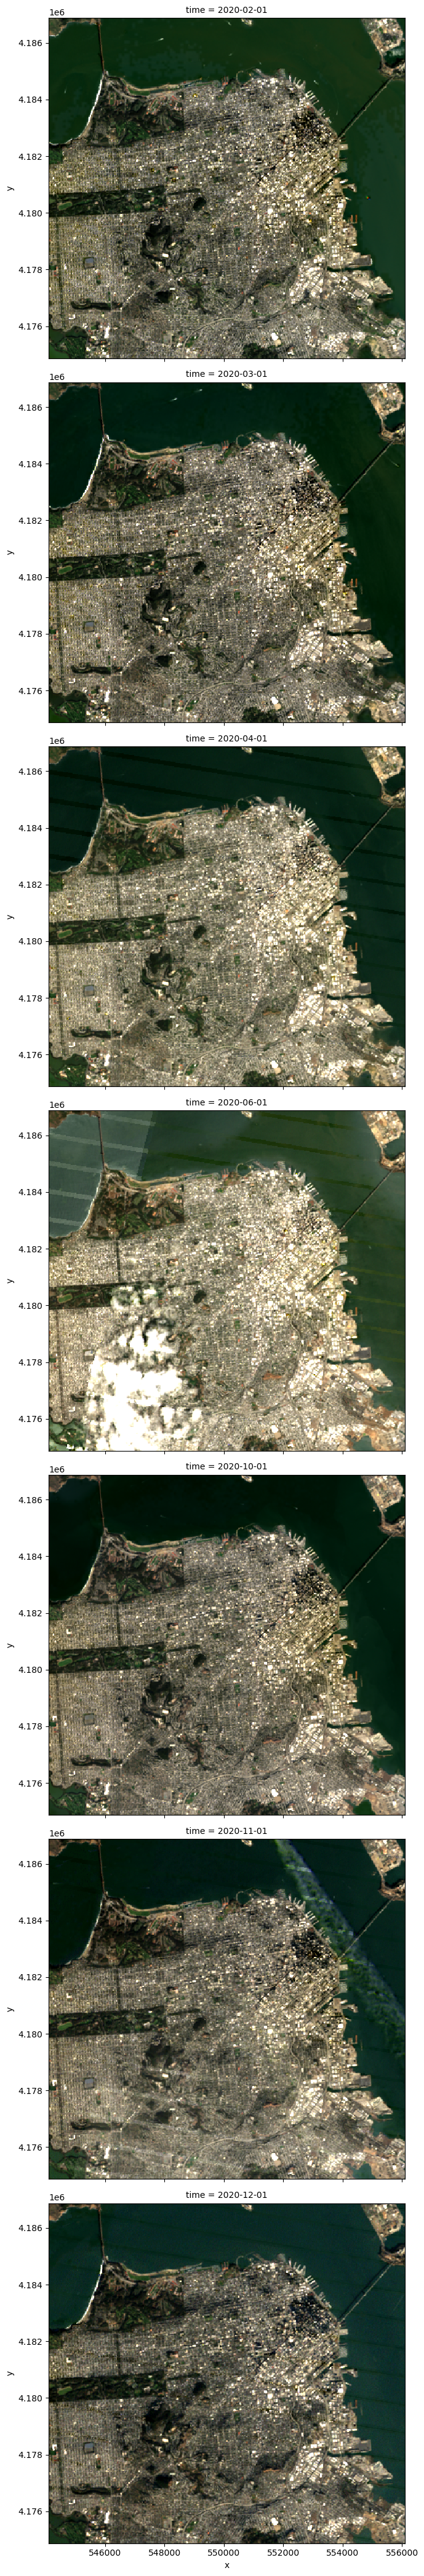

In [28]:
data.plot.imshow(row='time', rgb='band', robust=True, size=6);

## Running Complex Python Functions with Dask + Xarray

In the previous section we showed how `dask` can be used to pull data from the cloud while refining your search ahead of time to the data and resolutions that you are interested in. In this section we'll see how `dask` can be used to do some more complex analyses as well before pulling the data into memory.

`dask` does have a native package for interacting with images called `dask_image,` but it can be tricky to use with streaming data in chunks, which makes it difficult to use on large images stored elsewhere in the cloud. We will instead write some custom functions to be used on our dask data, so that we can import our data already transformed.

### Implementing Custom Functions with Dask
Let's start by looking at the normalized difference vegetation index (NDVI). In the cryosphere, this isn't likely to be an index that we use often, but it's a great stand in for how we can create custom functions in `dask`. This same principal could be applied to pull in our data as band ratios, or other preprocessing functions that we might be interested in. Similarly to above, we'll limit this to our area of interest.

In [29]:
area_of_interest = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
area_of_interest

<xarray.DataArray 'stackstac-04f270ee2829fe819c84478d86276848' (time: 183,
                                                                band: 5,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(183, 5, 400, 400), dtype=float64, chunksize=(1, 1, 400, 400), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2020-02-06T18:51:55.12...
    id                           (time) <U31 'LC08_L2SP_045033_20200206_02_T1...
  * band                         (band) <U6 'red' 'green' ... 'nir08' 'swir16'
  * x                            (x) float64 5.441e+05 5.441e+05 ... 5.561e+05
  * y                            (y) float64 4.187e+06 4.187e+06 ... 4.175e+06
    view:sun_azimuth             (time) float64 153.1 147.4 ... 144.5 155.1
    ...                           ...
    landsat:wrs_row              (time) <U3 '033' '033' '033' ... '035' '033'
    landsat:collection_number    <U2 '02'
    landsat:cloud_cover_land     (time) float64 0.19 0.0 0.94 ... 3.0 0.0 5.41
    title                        (band) <U28 'Red Band' ... 'Short-wave Infra...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(407580, 4037010, 694320, 4327...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 407580.00|\n| 0.00,-30.00, 4327230.00|\n| 0.0...
    resolution:  30

In [30]:
NDVI = (area_of_interest.sel(band='swir16') - 
        area_of_interest.sel(band='nir08')) / (area_of_interest.sel(band='swir16') + 
                                               area_of_interest.sel(band='nir08'))

Perhaps we are also interested in obtaining an average NDVI across the entire year. Like before we can write this calculation before computing so that we only keep the data that we're interested persistant in memory. The `persist` function is an alternative to calling `compute` that triggers the computation and stores the results so that subsequent computations can reuse these stored values. This can be useful if we intend to repeat a calculation.

In [33]:
with dask.diagnostics.ProgressBar():
    av_NDVI = NDVI.mean(dim='time').persist()

[########################################] | 100% Completed | 38.92 s


We can visualize this using `dask`'s built in plotting functionality.

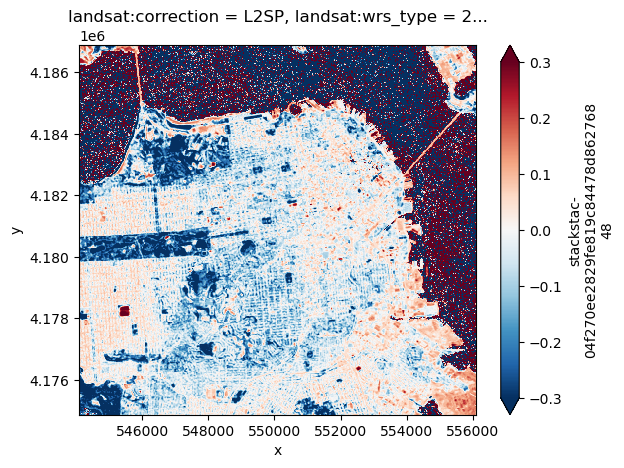

In [58]:
av_NDVI.plot.imshow(vmin=-0.3, vmax=0.3, cmap='RdBu_r')

### Operating Sci-kit Image with Dask for Quick Segmentation

What if we want to do something more complicated, like something that requires packages from `sklearn`? We can also pair `sklearn` functionality with dask arrays. First we'll take the yearly average of the luminance of our data.

In [38]:
def luminance(dask_arr):
    result = ((dask_arr.sel(band='red') * 0.2125) +
              (dask_arr.sel(band='green') * 0.7154) +
              (dask_arr.sel(band='blue') * 0.0721))
    return result

In [39]:
lum = luminance(area_of_interest)

In [40]:
av_lum = lum.median(dim='time')

In [41]:
av_lum

<xarray.DataArray 'stackstac-04f270ee2829fe819c84478d86276848' (y: 400, x: 400)>
dask.array<nanmedian, shape=(400, 400), dtype=float64, chunksize=(302, 302), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * x                            (x) float64 5.441e+05 5.441e+05 ... 5.561e+05
  * y                            (y) float64 4.187e+06 4.187e+06 ... 4.175e+06
    landsat:correction           <U4 'L2SP'
    landsat:wrs_type             <U1 '2'
    view:off_nadir               int64 0
    proj:epsg                    int64 32610
    ...                           ...
    description                  <U28 'Landsat Collection 2 Level-2'
    landsat:collection_number    <U2 '02'
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32610
    band                         <U6 'blue'
    title                        <U28 'Blue Band'

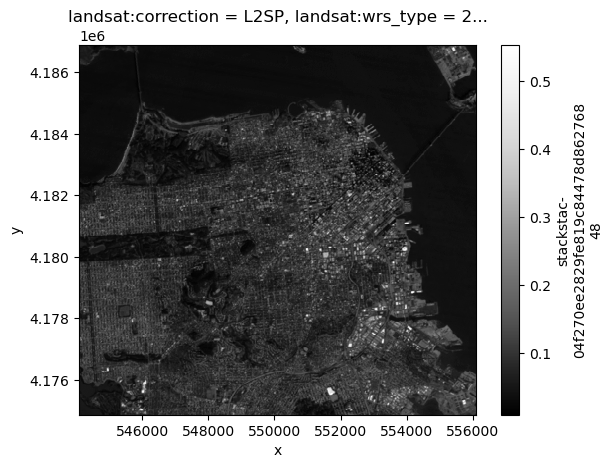

In [42]:
av_lum.plot.imshow(cmap='Greys_r')

We still haven't computed our data, so this is still operating in lazy load. However, we are about to switch over to using a function from another package, `sci-kit image`, and this function will require pulling the data into memory in order to run a more complex function. This means that it is important to have enough memory to allow for the function to store whatever copies of the data it needs while it is computing, but it will only save the output in memory.

In [43]:
from skimage.filters import gaussian

In [44]:
def apply_gaussian(arr):
    return gaussian(arr, sigma=(0, 0.1), preserve_range=True, mode='reflect')

In [45]:
smoothed = xr.apply_ufunc(apply_gaussian, av_lum,
                          dask='allowed', output_dtypes=[np.float64],
                          input_core_dims=[['x', 'y']], output_core_dims=[['x', 'y']])

In [46]:
np.mean(smoothed)

<xarray.DataArray 'stackstac-04f270ee2829fe819c84478d86276848' ()>
array(0.07944183)
Coordinates:
    landsat:correction           <U4 'L2SP'
    landsat:wrs_type             <U1 '2'
    view:off_nadir               int64 0
    proj:epsg                    int64 32610
    gsd                          int64 30
    landsat:collection_category  <U2 'T1'
    description                  <U28 'Landsat Collection 2 Level-2'
    landsat:collection_number    <U2 '02'
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32610
    band                         <U6 'blue'
    title                        <U28 'Blue Band'

Once we have run a gaussian filter on our data, we can run a simple threshold our images for a basic segmentation. This will not be as nice as segmentation done with more complex computer vision methods, but can be useful for finding easily delineated objects.

In [55]:
absolute_threshold = smoothed > 0.175

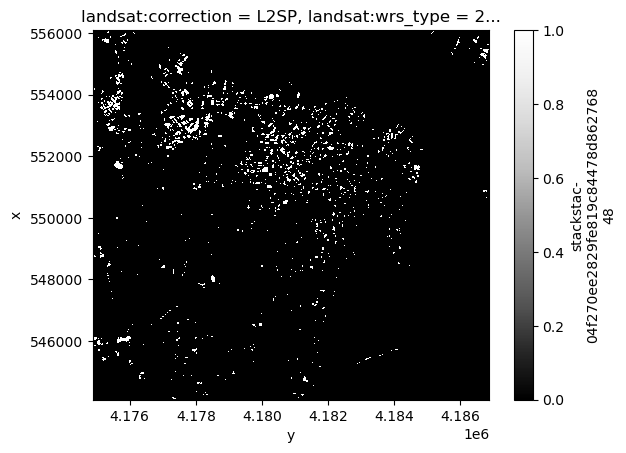

In [56]:
absolute_threshold.plot.imshow(cmap='Greys_r')

If we wanted to run machine learning models using `sci-kit learn` we could apply the same principle. The really beautiful thing about using `dask` for these tasks is that our initial dataset was estimated to be >600 GB, and we are able to do these relatively high level tasks while streaming in only 20.22 GB that we needed. If we needed to be careful, we could be even more specific about how we implement dask to ensure that we are incredibly efficient with our persistant memory usage.